# NEW VERSION TO HANDLE CHANGES IN LOGGING

In [50]:
import pandas as pd
import numpy as np
import json
import time
import re
import matplotlib.pyplot as plt

from datetime import datetime

filename = 'reports/report3.json'

In [51]:
with open(filename, encoding="utf-8") as f:
    target = f.read()

In [57]:
data = json.loads(target)
note_number = '4'

data[note_number]['data']['title']
data[note_number]['data']['content']
# start time
tstamp = data[note_number]['data']['key'][0]['timestamp']
print("Start Time: {}".format(datetime.fromtimestamp((tstamp)/1000.0)))

Start Time: 2022-07-10 23:25:03.072000


## Writing Length (Words Count)

In [70]:
content = data[note_number]['data']['content'].strip()
print(f"Note length: {len(content)} characters")
print(f"Note length: {len(content.split(' '))} words")

Note length: 50 characters
Note length: 8 words


## Writing Content

In [71]:
# text
print("Full note:")
print(content)
words_in_note = re.sub(r'[^\w\s]', '', content).lower().split(' ')

Full note:
use this note to check dismisses.
plan to kill
bad


In [7]:
import os
from pathlib import Path

pkl_file = Path(os.getcwd())
pkl_file = pkl_file.parents[0] / 'dict' / 'pickled-dict-full.pkl'
print(pkl_file)

unpickle_dict = pd.read_pickle(pkl_file)
expanded = unpickle_dict.explode('wordnet_ext').reset_index(drop=True)
expanded = expanded.explode('phrase_ext').reset_index(drop=True)

/Users/royjara/dev/hci_lab/journal/dict/pickled-dict-full.pkl


In [8]:
expanded['Word'] = expanded['Word'].str.strip()
expanded['wordnet_ext'] = expanded['wordnet_ext'].str.strip()
expanded['phrase_ext'] = expanded['phrase_ext'].str.strip()

In [9]:
target_words = pd.unique(expanded['Word'].dropna().apply(lambda x: x.strip()))
target_words = np.append(target_words, pd.unique(expanded['wordnet_ext'].dropna().apply(lambda x: x.strip())))
target_words = np.append(target_words, pd.unique(expanded['phrase_ext'].dropna().apply(lambda x: x.strip())))

In [10]:
def get_ngram(alist, n):# {
    holder = []
    for i in range(len(alist) - (n-1)): 
        temp = alist[i]
        for j in range(1,n):
            temp = temp+ " " + alist[i + j]
        holder.append(temp)
    return holder

In [11]:
words_to_analyze = words_in_note + get_ngram(words_in_note, 2)
words_to_analyze = words_to_analyze + get_ngram(words_in_note, 3)

In [12]:
filtered_content = [x for x in words_to_analyze if x in target_words]

In [13]:
cat_dict = {}

for word in filtered_content:
    # find category it belongs to
    res = expanded[expanded['Word'].str.fullmatch(word, na=False) ]
    cat = ''
    if len(res) > 0:
        cat = res['Strategy No.'].values[0]
        # print(cat)
    else:
        res = expanded[expanded['wordnet_ext'].str.fullmatch(word, na=False) ]
        if len(res) > 0:
            cat = res['Strategy No.'].values[0]
            # print(cat)
        else:
            res = expanded[expanded['phrase_ext'].str.fullmatch(word, na=False) ]
            if len(res) > 0:
                cat = res['Strategy No.'].values[0]
                # print(cat)
            else: 
                pass
                # print('not found')
            
    # print('*********************************')
    
    if cat in cat_dict.keys():
        cat_dict[cat]+=1
    else:
        cat_dict[cat] = 1

cat_dict = dict(sorted(cat_dict.items()))

print(f"results: {cat_dict}")

results: {'L2a': 1, 'L2b': 3, 'L2e': 9, 'L2f': 3}


([<matplotlib.axis.XTick at 0x7f958fb71be0>,
 [Text(0, 0, 'L2a'), Text(1, 0, 'L2b'), Text(2, 0, 'L2e'), Text(3, 0, 'L2f')])

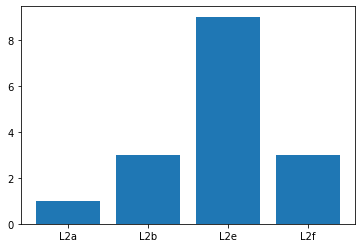

In [14]:
plt.bar(range(len(cat_dict)), list(cat_dict.values()), align='center')
plt.xticks(range(len(cat_dict)), list(cat_dict.keys()))

## Writing Behavior

JS EVT TIMESTAMP ==> TIME IN MILLISECONDS!


Analysis approach:
- no need to know actual time, just the difference between events
- plot the timestamps in the same order as indices.
- then bundle up all the rising ones as one session
- then analyze per session and combine!

<AxesSubplot:>

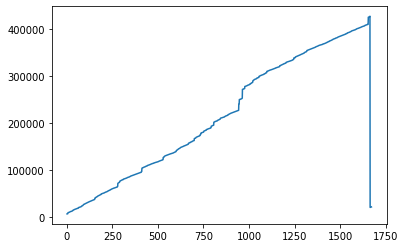

In [15]:
df = pd.DataFrame(data[note_number]['data']['key'])
df = df.drop([0])
df["timestamp"].plot()

In [16]:
df['timestamp_diff'] = df['timestamp'].diff()
df['session_id'] = df.apply(lambda row: 1 if row['timestamp_diff'] < 0 else 0, axis=1).cumsum()
df['pauses'] = df.apply(lambda row: 1 if row['timestamp_diff'] > 3000 else 0, axis=1)
df[['text', 'cursor', 'timestamp', 'session_id', 'timestamp_diff', 'pauses']][df['pauses']==1].head(3)

,text,cursor,timestamp,session_id,timestamp_diff,pauses
280,Today was a fine day. I went out with my frien...,"{'line': 0, 'ch': 210, 'sticky': None}",71324,0,6496.0,1
412,Today was a fine day. I went out with my frien...,"{'line': 0, 'ch': 253, 'sticky': None}",102784,0,6005.0,1
529,Today was a fine day. I went out with my frien...,"{'line': 0, 'ch': 339, 'sticky': None}",126398,0,4576.0,1


In [17]:
pause_list = df.index[df['pauses'] == 1].tolist()

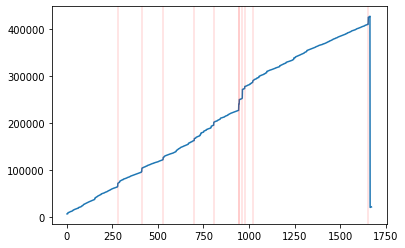

In [18]:
df["timestamp"].plot()
[plt.axvline(_x, linewidth=0.2, color='r') for _x in pause_list]
# missing ax labels (x-keystroke event, y-timestamp) 
# larger size
# red overlay lines represent pauses
# big drop is the resetting of the session --> could be adjusted to make continuous. 
# idk if there is any value in displaying the sessions

In [19]:
# writing duration -- aggregate per session_id and add results
a = df.groupby('session_id')['timestamp'].max()
print(f"Writing duration {(a.sum()/1000)/60:.2f} minutes")

Writing duration 7.48 minutes


In [20]:
# save to csv for further inspection.
df[['text', 'cursor', 'timestamp', 'session_id', 'timestamp_diff', 'pauses']][df['pauses']==1].to_csv('pauses.csv')

## Interactions with features

Simplify!
- separate into groups of interactions (columns): dismisses, accepts, l2dismisses
- but at the same time (before or after) 
- find unique for both 

- Marks can be either placeholder (L1/L3) or highlights (L2)
- dismisses are the L1/L3 dismisses
- accepts are the L1/L3 accepts
- l2dismisses are the 
- placeholder only relevant if marks has placeholder

In [24]:
data[note_number]['data'].keys()

dict_keys(['title', 'content', 'date', 'flag', 'marks', 'mouse', 'key', 'sidebar', 'popup', 'toggle', 'dismiss', 'accept', 'dismisslist'])

In [58]:
pd.DataFrame(data[note_number]['data']['sidebar'])

,timestamp,type,word,state,duration
0,1657520703072,start,NaN,NaN,NaN
1,29846,sidebar,should,start,NaN
2,30843,sidebar,NaN,stop,1006.0
3,60731,sidebar,kill,start,NaN
4,63380,sidebar,NaN,stop,2650.0
5,77483,sidebar,bad,start,NaN
6,79056,sidebar,NaN,stop,1582.0


In [59]:
pd.DataFrame(data[note_number]['data']['popup'])

,timestamp,type,word,popup_title,state,duration
0,1657520703072,start,NaN,NaN,NaN,NaN
1,29090,popup,should,Should Statment,start,NaN
2,29846,popup,NaN,NaN,stop,760.0
3,60013,popup,kill,None,start,NaN
4,60731,popup,NaN,NaN,stop,720.0
5,76733,popup,bad,Judgment,start,NaN
6,77483,popup,NaN,NaN,stop,753.0


In [60]:
pd.DataFrame(data[note_number]['data']['toggle'])

,timestamp,type,activated
0,1657520703072,start,NaN
1,27002,toggleL2,True


In [61]:
pd.DataFrame(data[note_number]['data']['dismiss'])

,timestamp,type,content,marks,suggestion,completed_amount
0,1657520703072,start,NaN,NaN,NaN,NaN
1,81714,NaN,use this note to check dismisses.\nplan to kil...,"[{'tag': 'L2-highlight', 'from': {'line': 2, '...","Without this judgment, I will",-1.0
2,86361,NaN,use this note to check dismisses.\nplan to kil...,"[{'tag': 'L2-highlight', 'from': {'line': 2, '...","Without this judgment, I will",4.0
3,141778,NaN,use this note to check dismisses.\nplan to kil...,"[{'tag': 'L2-highlight', 'from': {'line': 2, '...","Without this judgment, I will",-1.0
4,173832,NaN,use this note to check dismisses.\nplan to kil...,"[{'tag': 'L2-highlight', 'from': {'line': 2, '...","Beyond judgment, the situation and my feelings...",13.0


In [68]:
temp = pd.DataFrame(data[note_number]['data']['accept'])
temp[temp['suggestion'] != '']

,timestamp,type,suggestion,content,marks
0,1657520703072,start,NaN,NaN,NaN
1,33336,NaN,plan to,use this note to check dismisses.\nplan to sh...,"[{'tag': 'L2-highlight', 'from': {'line': 1, '..."
4,231130,NaN,"Without this judgment, I will",use this note to check dismisses.\nplan to kil...,"[{'tag': 'L2-highlight', 'from': {'line': 2, '..."


In [63]:
pd.DataFrame(data[note_number]['data']['dismisslist'])

""
